In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner

import jax
import jax.numpy as jnp
import numpyro

In [2]:
loc = 0
scale = 0.3
true = numpyro.distributions.TruncatedNormal(
    loc = loc, scale = scale, low = 0, high = 1,
)

In [3]:
n = 50
events = true.sample(jax.random.PRNGKey(0), (n,))
events.shape

(50,)

(array([2.52, 2.7 , 2.34, 0.54, 0.54, 0.36, 0.  , 0.  , 0.  ]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 [<matplotlib.patches.Polygon at 0x7f0b9c6bfd50>])

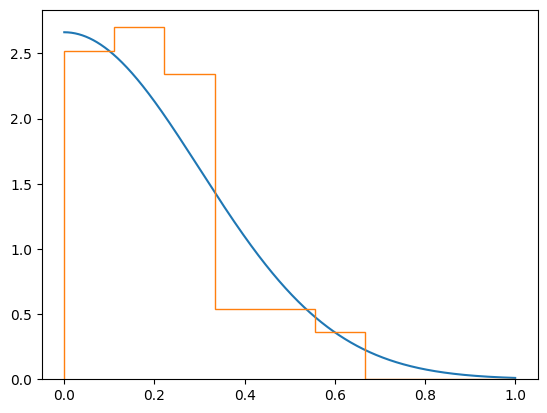

In [4]:
x = jnp.linspace(0, 1, 1_000)
y = jnp.exp(true.log_prob(x))
plt.plot(x, y)
plt.hist(
    events, bins = np.linspace(0, 1, 10), density = True, histtype = 'step',
)

In [5]:
def model(events):
    loc = numpyro.sample('loc', numpyro.distributions.Uniform(-0.3, 0.5))
    scale = numpyro.sample('scale', numpyro.distributions.Uniform(0.05, 0.7))
    with numpyro.plate('events', events.size):
        numpyro.sample(
            'obs',
            numpyro.distributions.TruncatedNormal(
                loc = loc, scale = scale, low = 0, high = 1,
            ),
            obs = events,
        )

In [6]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 10_000, num_samples = 10_000)
mcmc.run(jax.random.PRNGKey(1), events)
mcmc.print_summary()

sample: 100%|█████| 20000/20000 [00:09<00:00, 2083.64it/s, 3 steps of size 2.98e-01. acc. prob=0.80]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       loc     -0.02      0.13     -0.00     -0.24      0.18   1578.66      1.00
     scale      0.27      0.06      0.26      0.17      0.36   1545.12      1.00

Number of divergences: 0


In [7]:
samples = np.transpose([mcmc.get_samples()[par] for par in ('loc', 'scale')])

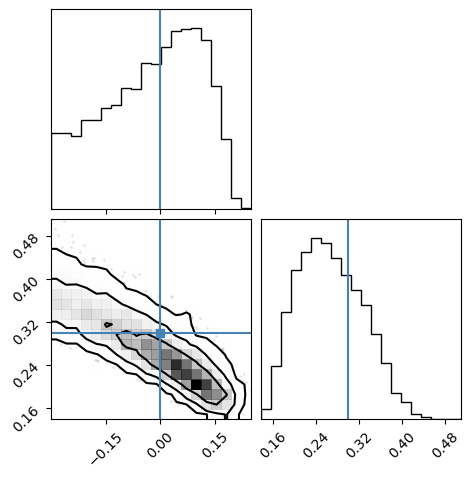

In [8]:
corner(samples, truths = [loc, scale], levels = [0.5, 0.9, 0.99]);